# 年輪データの状態空間モデル
* トレンドモデル

In [3]:
import os
from cmdstanpy import CmdStanModel
from pathlib import Path
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib

## データ読込み

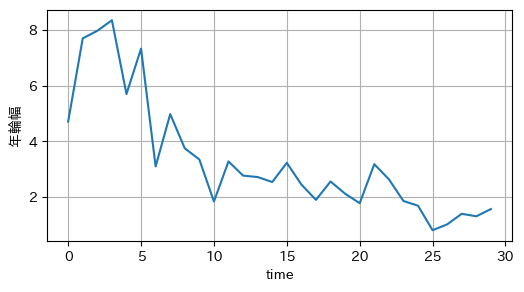

In [4]:
df = pd.read_csv("../data/nenrin.data", header=None)
df.columns = ["data"]

plt.figure(figsize=(6,3))
plt.plot(df["data"])
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.show()

In [16]:
stanfile = "../models_ts/trend_nenrin.stan"
model = CmdStanModel(stan_file=stanfile)

15:39:22 - cmdstanpy - INFO - compiling stan file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/trend_nenrin.stan to exe file /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/trend_nenrin
15:39:41 - cmdstanpy - INFO - compiled model executable: /home/karinog/work/study/bayesian-time-series-anomaly-detection/models_ts/trend_nenrin


In [17]:
N_tr = df["data"].shape[0]
y_tr = df["data"].values
data = {
    "N_tr": N_tr,
    "y_tr": y_tr
}

In [18]:
fit = model.sample(
    data=data,
    iter_warmup=300, iter_sampling=1000, chains=3, show_console=False,
    adapt_delta=0.999,
    max_treedepth=20,
)

15:39:43 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |██        | 00:00 Iteration:  100 / 1300 [  7%]  (Warmup)
chain 1 |████      | 00:00 Iteration:  301 / 1300 [ 23%]  (Sampling)
chain 1 |██████    | 00:00 Iteration:  600 / 1300 [ 46%]  (Sampling)
chain 1 |███████▎  | 00:00 Iteration:  800 / 1300 [ 61%]  (Sampling)
chain 1 |████████▋ | 00:00 Iteration: 1000 / 1300 [ 76%]  (Sampling)
chain 1 |██████████| 00:00 Iteration: 1200 / 1300 [ 92%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       

15:39:45 - cmdstanpy - INFO - CmdStan done processing.
15:39:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.1%)
	Use function "diagnose()" to see further information.


In [19]:
# 念の為診断
print(fit.diagnose())

Processing csv files: /tmp/tmphp3eg4_g/trend_nenrinegz4zij1/trend_nenrin-20230825153943_1.csv, /tmp/tmphp3eg4_g/trend_nenrinegz4zij1/trend_nenrin-20230825153943_2.csv, /tmp/tmphp3eg4_g/trend_nenrinegz4zij1/trend_nenrin-20230825153943_3.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 3000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.12, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete.



## 結果の確認

In [20]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,11.84710,1.875010,16.700300,-11.965900,9.25629,43.54090,79.3304,33.1787,1.022830
alpha[1],6.57767,0.051972,0.850255,5.125900,6.60699,7.92628,267.6490,111.9400,1.007650
alpha[2],6.88317,0.010144,0.501063,6.079990,6.88811,7.69231,2439.7000,1020.3700,1.000230
alpha[3],6.98381,0.034850,0.565495,6.078920,6.97384,7.93029,263.3080,110.1240,1.002790
alpha[4],6.80468,0.047713,0.632540,5.817440,6.78466,7.87780,175.7540,73.5066,1.006570
...,...,...,...,...,...,...,...,...,...
y_tr_hat[26],1.45256,0.021331,1.071870,-0.282153,1.43936,3.20947,2524.9600,1056.0300,1.000020
y_tr_hat[27],1.36050,0.021665,1.059580,-0.394363,1.35340,3.11454,2391.9000,1000.3800,1.000090
y_tr_hat[28],1.27522,0.019964,1.073570,-0.463608,1.24799,3.03999,2891.8700,1209.4800,0.999650
y_tr_hat[29],1.28306,0.020159,1.082190,-0.493892,1.26993,3.09698,2881.8900,1205.3100,0.999674


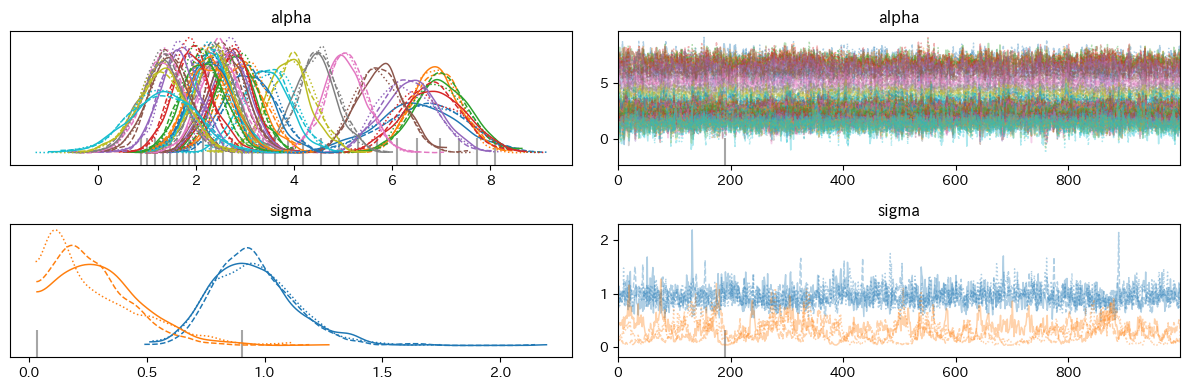

In [22]:
output = az.from_cmdstanpy(posterior=fit)
az.plot_trace(output, var_names=["alpha","sigma"])
plt.tight_layout()

## EAP推定
* 対数尤度が「異常度」の指標になる
* $\log L(y | \hat y, \sigma)$の意味
    * モデルが$\hat y$を推定したときにデータが$y$を取りうる確率の対数
    * 発生確率が小さくなるほど対数尤度も小さくなる
    * 発生確率が小さい＝めったに起こらない＝異常！と考える

In [23]:
samples = fit.stan_variables()

alpha = samples["alpha"].mean(0)
sigma = samples["sigma"].mean(0)
alpha, sigma

(array([6.5776733 , 6.88316605, 6.98381038, 6.80468126, 6.33431411,
        5.74604288, 5.04438582, 4.46372904, 3.9312277 , 3.46506817,
        3.10992088, 2.92958801, 2.81051827, 2.72688218, 2.6655615 ,
        2.59916568, 2.48959121, 2.38803929, 2.33448003, 2.29678305,
        2.27168371, 2.24716012, 2.11813252, 1.9019711 , 1.65892592,
        1.44686227, 1.33312633, 1.2955811 , 1.29268333, 1.31222344]),
 array([0.95234764, 0.28747588]))

In [24]:
y_tr_hat_lower, y_tr_hat_upper = np.quantile(samples["y_tr_hat"], [0.025,0.975], axis=0)
y_tr_hat_mean = samples["y_tr_hat"].mean(0)

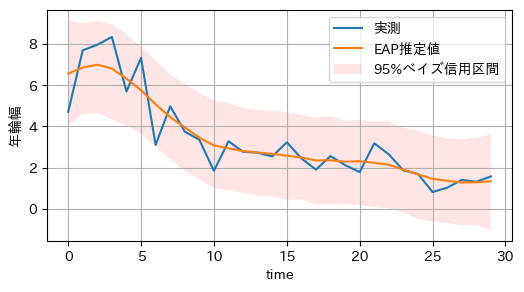

In [25]:
plt.figure(figsize=(6,3))
plt.plot(y_tr, label="実測")
plt.plot(y_tr_hat_mean, label="EAP推定値")
plt.fill_between(
    np.arange(N_tr), y1=y_tr_hat_lower, y2=y_tr_hat_upper, 
    alpha=0.1, color="r", edgecolor=None, label="95%ベイズ信用区間"
)
plt.xlabel("time")
plt.ylabel("年輪幅")
plt.grid()
plt.legend()
plt.show()

EOF